In [82]:

import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from IPython.display import display
import random
import json


In [83]:
import plotly.graph_objs as go
import pandas as pd

# create a pandas dataframe with sample data
data = {
    'Name': ['John', 'Jane', 'Jack', 'Jill', 'Jim'],
    'Age': [25, 30, 35, 40, 45],
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male']
}
df = pd.DataFrame(data)

# create separate traces for each gender
male_trace = go.Scatter(
    x=df[df['Gender']=='Male']['Age'],
    y=df[df['Gender']=='Male']['Name'],
    mode='markers',
    name='Male',
    marker=dict(color='blue', size=10)
)

female_trace = go.Scatter(
    x=df[df['Gender']=='Female']['Age'],
    y=df[df['Gender']=='Female']['Name'],
    mode='markers',
    name='Female',
    marker=dict(color='red', size=10)
)

# create a layout for the scatter plot
layout = go.Layout(
    title='Sample Scatter Plot',
    xaxis=dict(title='Age'),
    yaxis=dict(title='Name'),
    hovermode='closest'
)

# create a figure with the traces and layout
fig = go.Figure(data=[male_trace, female_trace], layout=layout)

# update the hover behavior to highlight other points of the same gender
fig.update_traces(
    hovertemplate='<br>'.join([
        'Age: %{x}',
        'Name: %{y}',
        'Gender: %{marker.color}'
    ])
)

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=list([
                dict(
                    args=[
                        {"visible": [True, False]},
                        {"title": "Male Only"}
                    ],
                    label="Male",
                    method="update"
                ),
                dict(
                    args=[
                        {"visible": [False, True]},
                        {"title": "Female Only"}
                    ],
                    label="Female",
                    method="update"
                ),
                dict(
                    args=[
                        {"visible": [True, True]},
                        {"title": "All"}
                    ],
                    label="All",
                    method="update"
                )
            ]),
        )
    ]
)

# show the figure
fig.show()


In [84]:
def extract_chosen_isolates(
    chosen_isolates: pd.DataFrame, matrix_EU: pd.DataFrame
) -> pd.DataFrame:
    """
    Select the chosen isolates from the script. Return a DataFrame only containing the rows of selected isolates
    """
    chosen_rows = matrix_EU["Isolate"].isin(chosen_isolates["Isolate"])
    return matrix_EU[chosen_rows]

In [85]:
def extract_valid_ranges(antibiotic_ranges: dict) -> dict:
    """Extracts the upper and lower limit of an antibiotic from a dictionary"""
    valid_ranges = {}
    for antibiotic, conc_range in antibiotic_ranges['ASTar BC G+ (development)'].items():
        lower_limit, upper_limit = conc_range.split()[::2] # remove '-' from list using [::2]
        valid_ranges[antibiotic] = (lower_limit, upper_limit)
    return valid_ranges

In [86]:
def find_digits(SIR: str) -> int:
    """Find numbers in a string"""
    digit = ""
    for character in SIR:
        if character.isdigit() or character == ".":
            digit += character
    return float(digit)

In [87]:
def parse_SIR(SIR: str) -> bool:
    """
    Find the isolates with valid SIRs. Not 'Missing BP'
    and not 'nip'.
    """
    if SIR.startswith("Missing BP"):
        return False
    if SIR == "nip":
        return False
    return True      

In [88]:
def extract_SIR(chosen_isolates: pd.DataFrame, antibiotics: list) -> dict:
    """
    Extract all SIRs for an antibiotic. Returns a dictionary
    with antibiotcs as keys and lists of the isolates and their
    SIRs in tuples as value.
    """
    chosen_isolates_SIR = {antibiotic: [] for antibiotic in antibiotics}
    
    for index, row in chosen_isolates.iterrows():
        isolate, pathogen, antibiotic_SIR = row[0], row[1], list(row[3:].items())
        for antibiotic, SIR in antibiotic_SIR:
            if parse_SIR(SIR):
                mic_category = SIR[0]
                mic = find_digits(SIR)
                chosen_isolates_SIR[antibiotic].append((isolate, np.log2(mic), mic_category))
            else:
                # If SIR = "Missing BP" or "nip"
                chosen_isolates_SIR[antibiotic].append((isolate, SIR, None))
    return chosen_isolates_SIR

In [89]:
def extract_mic_data(chosen_isolates_SIR: dict, antibiotics: list) -> list:
    """
    Extract the mic-values of each isolate for each antibiotic.
    Returns a nested list. Each list represents the mic-values of 
    all isolates for an antibiotic.
    """
    mic_values = []
    # Iterate over all antibiotics
    for antibiotic in antibiotics:
        # Create a list to hold the mic-values of isolates for that abx
        antibiotic_mic_values = []
        # Get value of current abx. List of (isolate, mic_value, mic_category)
        SIR_data = chosen_isolates_SIR[antibiotic]
        for isolate, mic_value, mic_category in SIR_data:
            antibiotic_mic_values.append((mic_value, mic_category))
        mic_values.append(antibiotic_mic_values)
    return mic_values

In [90]:
def filter_mic_values(chosen_isolates_SIR: dict) -> None:
    """
    Remove the tuples that have None in their SIR data
    """
    for antibiotic, SIR_data in chosen_isolates_SIR.items():
        # tup = (isolate, mic_value, mic_category)
        chosen_isolates_SIR[antibiotic] = list((tup for tup in SIR_data if tup[2] is not None))
    return chosen_isolates_SIR

In [91]:
def count_isolates_per_concentration_per_antibiotic(chosen_isolates_SIR: dict, concentration_range: list, antibiotics: list) -> dict:
    isolates_per_concentration_per_antibiotic = {antibiotic: {conc: 0 for conc in concentration_range} for antibiotic in antibiotics}
    for abx, SIR_data in chosen_isolates_SIR.items():
        for (isolate, mic_value, mic_category) in SIR_data:
            isolates_per_concentration_per_antibiotic[abx][mic_value] += 1
        
        isolates_per_concentration_per_antibiotic[abx] = dict(sorted(isolates_per_concentration_per_antibiotic[abx].items()))
    return isolates_per_concentration_per_antibiotic

In [92]:
def collect_number_of_isolates_per_concentration(isolates_per_concentration_per_antibiotic: dict, concentration_range: list) -> dict:
    number_of_isolates_per_concentration = {conc: [] for conc in concentration_range}
    for antibiotic, isolates_per_concentration in isolates_per_concentration_per_antibiotic.items():
        for concentration, number_of_isolates in isolates_per_concentration.items():
            number_of_isolates_per_concentration[concentration].append(number_of_isolates)
    return number_of_isolates_per_concentration
            

In [93]:

def dotplot(antibiotics: list, concentration_range: list, mic_data: list) -> None:    
    mic_dict = {"S": ("limegreen", "Sensitive"), "I": ("gold", "Intermediate"), "R": ("tomato", "Resistant")}
    
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)
    
    
    jitter = 0.15
    x_axis = [i for i in range(len(antibiotics))]
    for x_value, abx_mic_data in zip(x_axis, mic_data):
        for mic_value, mic_category in abx_mic_data:
            try:
                color, _ = mic_dict[mic_category]            
            except ValueError:
                raise ValueError(f"Invalid key for mic_dict. Please use S, I or R. Entered key: {mic_category}")
            x_value_jitter = x_value + np.random.uniform(-jitter, jitter)
            mic_value_jitter = mic_value + np.random.uniform(-jitter, jitter)
            ax.scatter(x_value_jitter, mic_value_jitter, color=color, edgecolors=color, alpha=0.5)
    
    green_patch = mpatches.Patch(color=mic_dict["S"][0], label=mic_dict["S"][1])
    yellow_patch = mpatches.Patch(color=mic_dict["I"][0], label=mic_dict["I"][1])
    red_patch = mpatches.Patch(color=mic_dict["R"][0], label=mic_dict["R"][1])
    
    
    # add labels and title
    ax.set_xticks(x_axis)
    ax.set_xticklabels(antibiotics, rotation=90)
    ax.set_yticks(concentration_range)
    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.set(xlabel="Antibiotics", ylabel="log2(MIC Values)")
    ax.set_title('log2(MIC Values) for Different Strains')
    plt.legend(handles=[green_patch, yellow_patch, red_patch])
    # display plot
    plt.show()

In [94]:
def filter_isolates_per_concentration(isolates_per_concentration: dict) -> dict:
    """Removes concentrations where no isolates appear"""
    filtered_isolates_per_concentration = {}
    for concentration, number_of_isolates in isolates_per_concentration.items():
        # If the concentration has 0 isolates for all antibiotics, leave it
        if all(n == 0 for n in number_of_isolates):
           pass
        else: 
        # Add it to the filtered dictionary else
            filtered_isolates_per_concentration[concentration] = number_of_isolates
    return filtered_isolates_per_concentration

In [95]:
def plot_thresholds(ax, sir_threshold:dict) -> None:
    for antibiotic, thresholds in sir_threshold.items():
        
        pass

In [96]:
def stacked_bar_plots(antibiotics: list, isolates_per_concentration: dict, sir_threshold:dict,width: float=0.5) -> None:
    # Set up color gradient
    filtered_isolates_per_concentration = filter_isolates_per_concentration(isolates_per_concentration)
    NUM_COLORS = len(filtered_isolates_per_concentration)
    cm = plt.get_cmap("gist_rainbow")
    
    fig, ax = plt.subplots()
    
    # Leave empty space on right side for legend
    fig.subplots_adjust(right=0.8)
    bottom = np.zeros(len(antibiotics))
    
    for index, (concentration, number_of_isolates) in enumerate(filtered_isolates_per_concentration.items()):
        color = cm(index/NUM_COLORS)
        ax.bar(antibiotics, number_of_isolates, width=width, label=round(2**concentration, 5), bottom=bottom, color=color)
        bottom += number_of_isolates
    
    plt.xticks(rotation=90)
    ax.set_title("Number of isolates per concentration per antibiotic")

    handels, labels = ax.get_legend_handles_labels()
    ax.legend(handels[::-1], labels[::-1],loc="center left", bbox_to_anchor=(0.8, 0.5), bbox_transform=fig.transFigure)

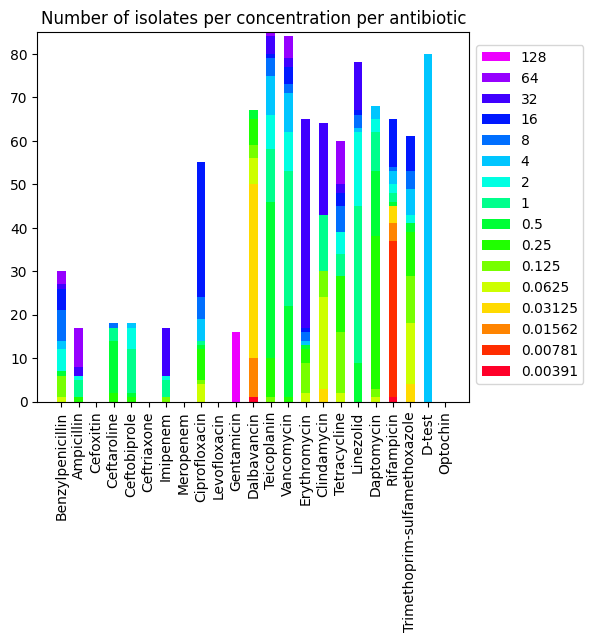

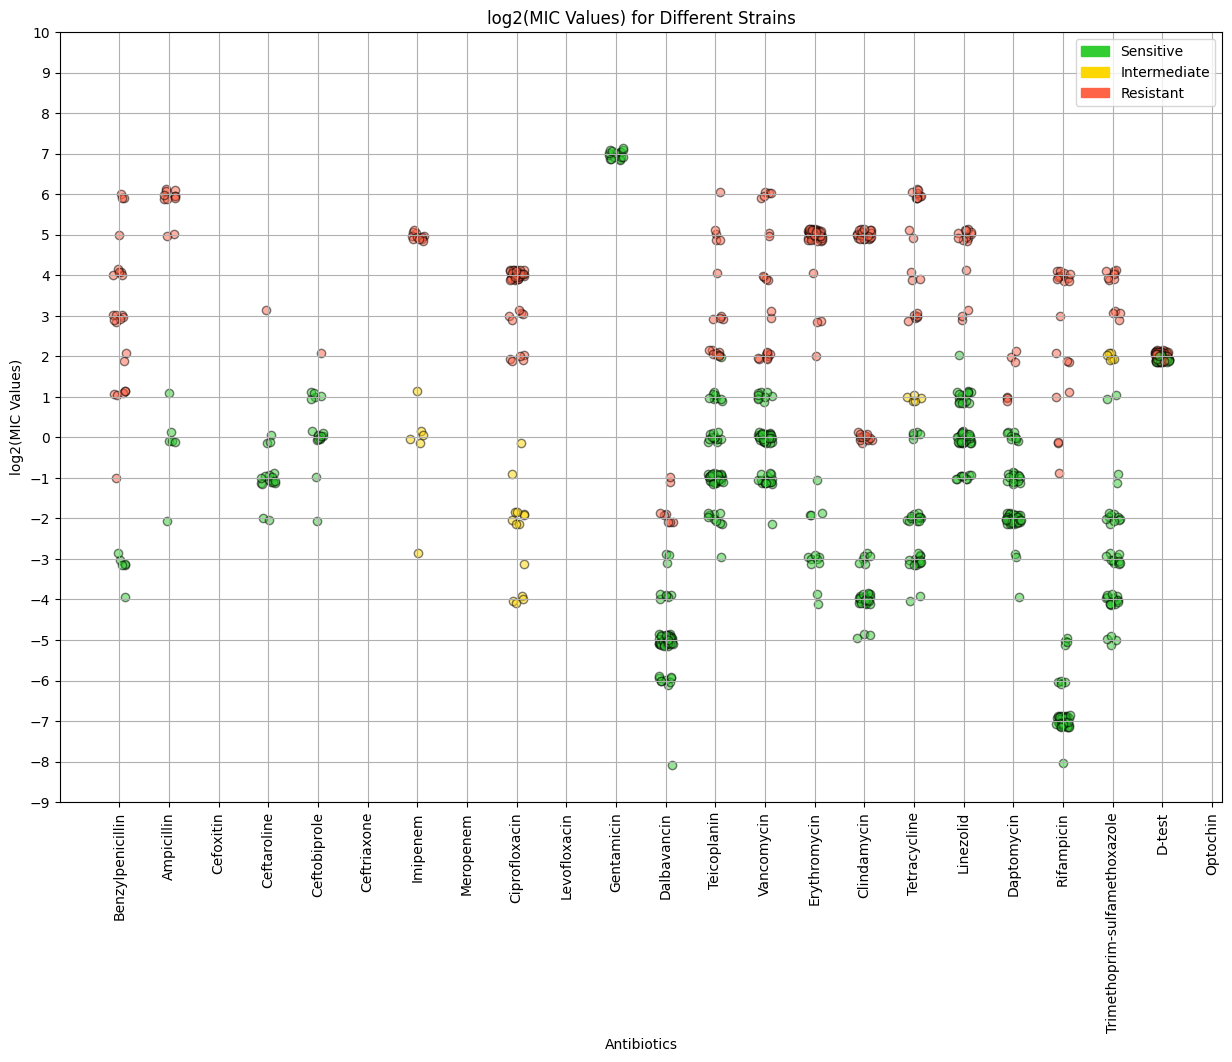

In [97]:
def main():
    # Load files
    chosen_isolates_list = pd.read_csv("Chosen_isolates_list.csv")
    CIB = pd.ExcelFile("CIB_TF-data_AllIsolates_20230302.xlsx")
    matrix_EU = pd.read_excel(CIB, "matrix EU")
    sir_thresholds = json.load(open("sir_thresholds.json"))
    #print(sir_thresholds)
    #loaded_ranges = json.load(open("ranges.json"))
    
    # Creates dictionary with antibiotics as keys and their on-scale ranges as value (lower, upper)
    #antibiotic_ranges = extract_valid_ranges(loaded_ranges)
    
    # Select isolates
    chosen_isolates = extract_chosen_isolates(chosen_isolates_list, matrix_EU)
    
    # Concentrations in panel
    concentration_range = [i for i in range(-9, 11)]
    
    # Create array of isolate names and antibiotic names
    #chosen_isolates_names = chosen_isolates_list.values.reshape(1, -1)[0]
    antibiotics = list(chosen_isolates.columns[3:])
    
    # Extract all SIRs for an antibiotic.
    chosen_isolates_SIR = extract_SIR(chosen_isolates, antibiotics)
    
    # Remove the tuples that have None in their SIR data
    filtered_chosen_isolates_SIR = filter_mic_values(chosen_isolates_SIR)
    
    # Count number of isolates per concentration
    isolates_per_concentration_per_antibiotic = count_isolates_per_concentration_per_antibiotic(filtered_chosen_isolates_SIR, concentration_range, antibiotics)
    
    isolates_per_concentration = collect_number_of_isolates_per_concentration(isolates_per_concentration_per_antibiotic, concentration_range)
    
    stacked_bar_plots(antibiotics, isolates_per_concentration, sir_thresholds)
    
    # Extract the mic-values of each isolate for each antibiotic.
    mic_data = extract_mic_data(filtered_chosen_isolates_SIR, antibiotics)
    
    
    dotplot(antibiotics, concentration_range, mic_data)
    
if __name__ == "__main__":
    main()
